Sentinel-1 SAR wind products are available here: http://thredds.nersc.no/thredds/catalog/sarvind/SarVind/2019/catalog.html. Currently, the products must be downloaded because of an error on the thredds server.

External datasets that need to be downloaded:

- https://oceancolor.gsfc.nasa.gov/docs/distfromcoast/

Validation datasets:

- land stations (only use the ones closer than 1 km from the coast)
  - https://thredds.met.no/thredds/catalog/met.no/observations/stations/catalog.html
- wind buoys
  - https://thredds.met.no/thredds/catalog/obs/buoy-svv-e39/catalog.html
  - https://thredds.met.no/thredds/catalog/obs/kystverketbuoy/catalog.html

In [1]:
import os, sys
sys.path.append('/home/vagrant/project')
sys.path.append('/vagrant')
os.environ['PROJ_LIB'] = '/home/vagrant/Miniconda3-4.6.14-Linux-x86_64/envs/py3openwind/share/proj'
os.environ['DJANGO_SETTINGS_MODULE'] = 'project.settings'

In [2]:
import django
django.setup()

from django.conf import settings

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from nansat.nansat import Nansat
from nansat.domain import Domain
from nansat.tools import haversine
from openwind import sar_wind
from geospaas_wind.utils import wind_from_sar_and_arome_forecast

In [99]:
fn = 'http://thredds.nersc.no/thredds/dodsC/sarvind/SarVind/2019/08/21/WIND_S1B_IW_GRDM_1SDV_20190821T155906_20190821T155939_017686_021461_7D4D.nc'
#fn = '/vagrant/WIND_S1B_IW_GRDM_1SDV_20190821T155906_20190821T155939_017686_021461_7D4D.nc'

In [100]:
n = Nansat(fn)

OSError: http://thredds.nersc.no/thredds/dodsC/sarvind/SarVind/2019/08/21/WIND_S1B_IW_GRDM_1SDV_20190821T155906_20190821T155939_017686_021461_7D4D.nc: File does not exist

In [6]:
lon, lat = n.get_geolocation_grids()

In [14]:
u = n['U']
v = n['V']

In [15]:
%matplotlib inline
import cartopy.feature as cfeature
from cartopy import config
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

Text(0.5, 1.05, 'Meridional wind speed')

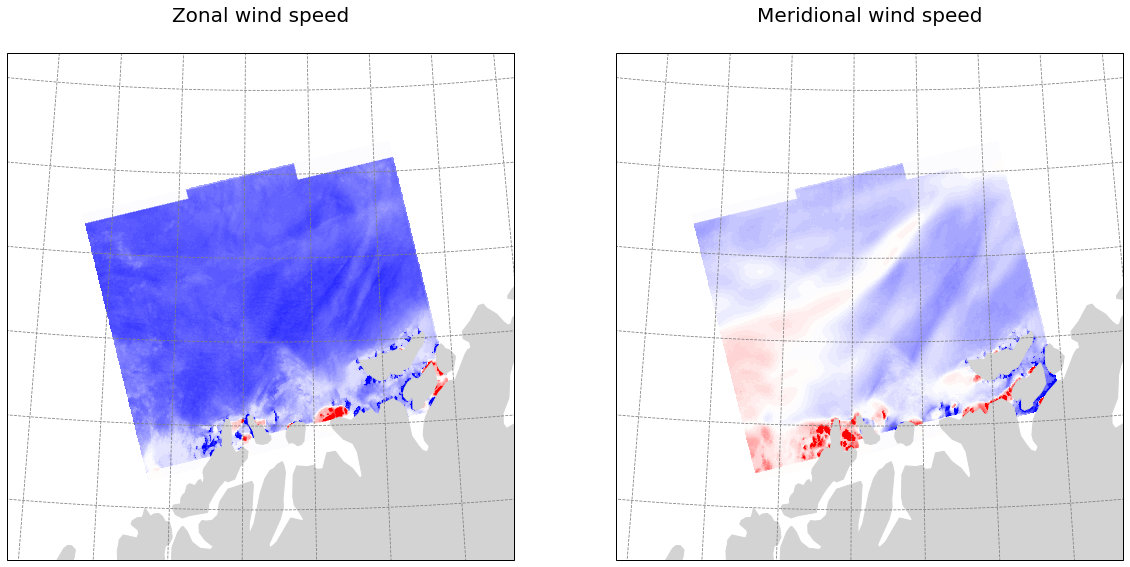

In [17]:
globe = ccrs.Globe(ellipse='WGS84', semimajor_axis=6378137, flattening=1/298.2572235604902)
proj = ccrs.Stereographic(central_longitude=np.mean(lon), central_latitude=np.mean(lat), globe=globe)
#proj = ccrs.Stereographic(central_longitude=15, central_latitude=80, globe=globe)

fig, axs = plt.subplots(1, 2, subplot_kw={'projection': proj}, figsize=(20, 20))
extent = [np.min(lon)-.5, np.max(lon)+.5, np.min(lat)-.5, np.max(lat)+.5]
land_f = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray')

axs[0].set_extent(extent, crs=ccrs.PlateCarree())
axs[0].gridlines(color='gray', linestyle='--')
axs[0].add_feature(land_f)
#axs[0].coastlines(resolution='10m')
axs[0].contourf(lon, lat, u, 200, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='bwr')
axs[0].set_title('Zonal wind speed', y=1.05, fontsize=20)

axs[1].set_extent(extent, crs=ccrs.PlateCarree())
axs[1].gridlines(color='gray', linestyle='--')
axs[1].add_feature(land_f)
#axs[1].coastlines(resolution='10m')
axs[1].contourf(lon, lat, v, 200, vmin=-10, vmax=10, transform=ccrs.PlateCarree(), cmap='bwr')
axs[1].set_title('Meridional wind speed', y=1.05, fontsize=20)

Find overlapping MET stations

In [16]:
from geospaas.catalog.models import Dataset
sar_wind = Dataset.objects.filter(dataseturi__uri__contains='WIND_S1')
coll_dict = {}
for ds in sar_wind:
    coll_dict[ds.pk] = {}
    # Find overlapping met stations (check for wind speed parameter)
    coll_dict[ds.pk]['metno_obs_stations'] = Dataset.objects.filter(
                                    entry_id__contains='metno_obs', 
                                    time_coverage_start__lt=ds.time_coverage_start, 
                                    time_coverage_end__gt=ds.time_coverage_end, 
                                    geographic_location__geometry__intersects=ds.geographic_location.geometry)
    # Find overlapping met wind buoys (check for wind speed parameter)
    coll_dict[ds.pk]['buoys'] = Dataset.objects.filter(
                                    dataseturi__uri__contains='buoy_svv', 
                                    time_coverage_start__lt=ds.time_coverage_start, 
                                    time_coverage_end__gt=ds.time_coverage_end, 
                                    geographic_location__geometry__intersects=ds.geographic_location.geometry)        

In [17]:
coll_dict

{2266: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2267: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2268: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2269: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2270: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2271: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2272: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2273: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2274: {'metno_obs_stations': <QuerySet [<Dataset: METEOROLOGICAL STATIONS//1910-08-28T18:00:00+00:00>]>,
  'buoys': <QuerySet []>},
 2275: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2276: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2277: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2278: {'metno_obs_stations': <QuerySet []>, 'buoys': <QuerySet []>},
 2279: {'metno_obs_stations

In [79]:
pk = 2291
sar_wind0 = Dataset.objects.get(pk=pk)
met_station = coll_dict[pk]['metno_obs_stations'][0]

In [80]:
met_station

<Dataset: METEOROLOGICAL STATIONS//1910-08-28T18:00:00+00:00>

In [81]:
import netCDF4
nc_met_station = netCDF4.Dataset(met_station.dataseturi_set.get().uri)

In [82]:
nc_met_station

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    station_name: BJØRNØYA
    wigos_identifier: 0-20000-0-01028
    wmo_identifier: 01028
    date_created: 2019-08-29T16:47:21.770380+00:00
    Conventions: ACDD-1.3,CF-1.6
    title: Observations from station BJØRNØYA SN99710
    institution: Norwegian Meteorological Institute
    source: Meterological surface observation via frost.met.no
    history: 2019-08-29T16:47:21.770380+00:00: frost write netcdf
    references: 
    acknowledgment: frost.met.no
    comment: Observations based on data from frost.met.no
    creator_email: observasjon@met.no
    creator_name: Norwegian Meteorological Institute
    creator_url: https://met.no
    geospatial_bounds: POINT(19.005000 74.516700)
    geospatial_bounds_crs: latlon
    geospatial_lat_max: 74.516700
    geospatial_lat_min: 74.516700
    geospatial_lon_max: 19.005000
    geospatial_lon_min: 19.005000
    id: metno_obs_SN99710
    keywords: obser

In [87]:
import datetime
from dateutil.parser import parse
reftime = parse(nc_met_station.variables['time'].units.split()[2])
dt = sar_wind0.time_coverage_start.replace(tzinfo=None) - reftime
ind = np.argmin(np.abs(dt.total_seconds()-nc_met_station.variables['time'][:].data))

In [88]:
parse(nc_met_station.variables['time'].units.split()[2]) + \
    datetime.timedelta(seconds=nc_met_station.variables['time'][:].data[ind])

datetime.datetime(2019, 8, 27, 5, 50)

In [90]:
sar_wind0.time_coverage_start

datetime.datetime(2019, 8, 27, 5, 26, 52, 133869, tzinfo=<UTC>)

In [91]:
nc_met_station.variables['wind_speed_10m']

<class 'netCDF4._netCDF4.Variable'>
float32 wind_speed_10m(time)
    long_name: Mean wind speed
    coverage_content_type: coordinate
    standard_name: wind_speed
    units: m s-1
    _ChunkSizes: 1024
unlimited dimensions: time
current shape = (324809,)
filling off

In [98]:
nc_met_station.variables['wind_speed_10m'][:].data[ind]

9.96921e+36